# モジュールのインポート

In [11]:
import re
import numpy as np
import pandas as pd
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import japanize_matplotlib
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.clustering import TimeSeriesKMeans

import openpyxl
from openpyxl.drawing.line import LineProperties
from openpyxl.chart.shapes import GraphicalProperties
from openpyxl.chart.text import RichText
from openpyxl.drawing.text import Paragraph, ParagraphProperties, CharacterProperties, Font

# 必要情報を入力

In [108]:
# 各フォルダの読み込み
folder_list = glob.glob(r'C:\Users\west7\OneDrive\デスクトップ\raman処理用\data\*')
# folder_list = glob.glob(r'C:\Users\r-swx\OneDrive\デスクトップ\raman_data\data\*')

# データの区切りを指定（タブ：'\t', コンマ：',', セミコロン：';'）
sep = '[,;\t]'

# excelタイトル
graph_title = 'raman'
# excelファイルの保存先のパス
excel_path = r'C:\Users\west7\OneDrive\デスクトップ\raman処理用\\' + graph_title + '.xlsx'
# excel_path = r'C:\Users\r-swx\OneDrive\デスクトップ\raman_data\\' + graph_title + '.xlsx'

# データの読み込み

In [109]:
file_dic = {}
for n, folder in enumerate(folder_list):
    file_dic[f'data_{n+1}'] = glob.glob(folder + '\*')

df_list = []

for folder in file_dic:
    # フォルダ内にファイルがある場合
    if len(file_dic[folder]) > 0:
        # 各種データ保存用のディクショナリを作成
        data_dic = {}
        
        # テクストファイルの読み込み
        for file in file_dic[folder]:
            # ファイル名の切り取り
            file_name = re.split('[\\\\.]', file)[8]

            # 一時保存用リストの作成
            temp_list = []

            # スペクトルデータの読み込み
            with open(file, encoding='utf-8') as f:
                for row in f:
                    row = row.strip()
                    temp_list.append(re.split(sep, row)) 
            temp_list = temp_list[32:1069]

            # ディクショナリへデータの格納
            data_dic[file_name] = temp_list

        # 空のデータフレームを作成
        df = pd.DataFrame()

        # フォルダ内データをデータフレームに追加
        for key in data_dic:
            intensity_list = []
            wave_list = []

            for n in range(len(data_dic[key])):
                intensity_list.append(data_dic[key][n][3])

            for n in range(len(data_dic[key])):
                wave_list.append(data_dic[key][n][0])

            df['Raman Shift'] = wave_list
            df[key] = intensity_list

        df = df.astype(float)
        df = df.sort_values(by=['Raman Shift'], ascending=True).reset_index(drop=True)

        df_list.append(df)

    else:
        break

# グラフの可視化

In [110]:
# X軸の最大・最小の設定
XLIM_MIN = 0
XLIM_MAX = 1
# Y軸の最大・最小の設定
YLIM_MIN = -1000
YLIM_MAX = 4000
# 軸ラベルの設定
XLABEL = 'Raman Shift [cm^-1]'
YLABEL = 'Intensity [a.u.]'
# グラフサイズ
GRAPH_SIZE = (8, 6)
# フォントサイズ
FONTS_SIZE = 14

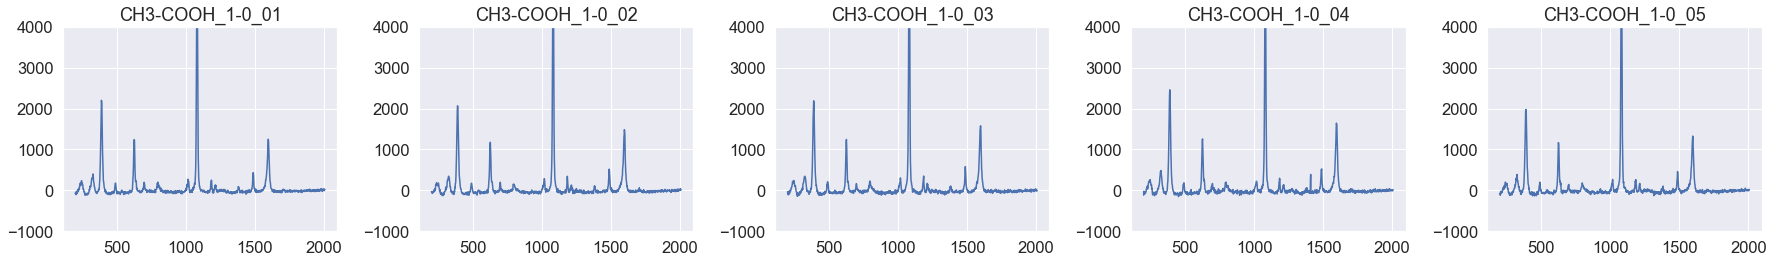

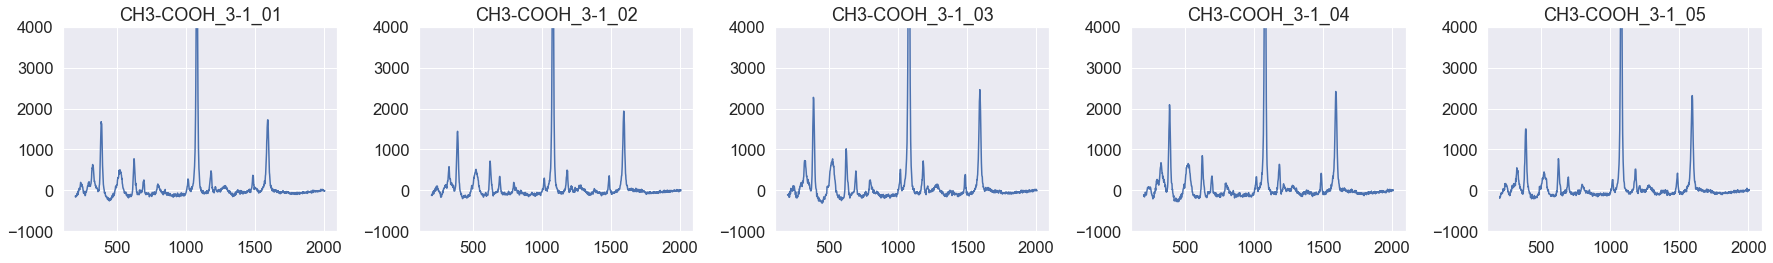

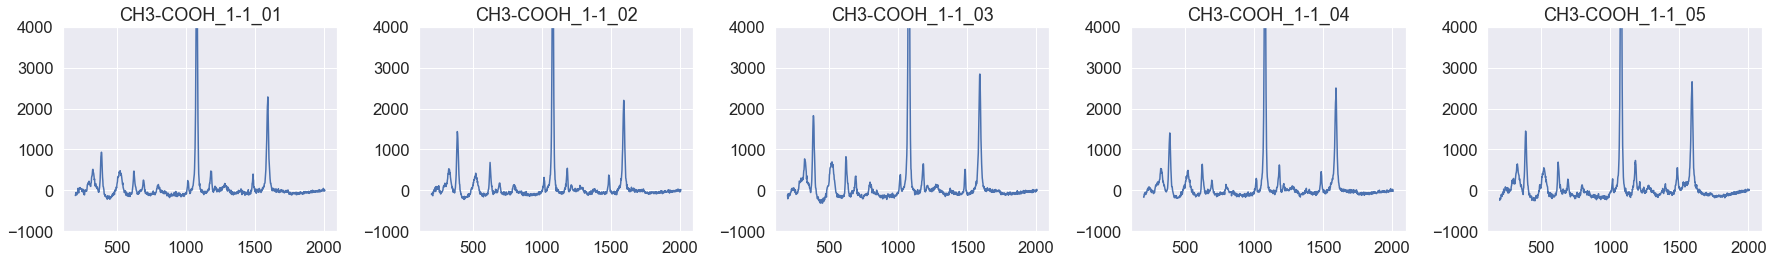

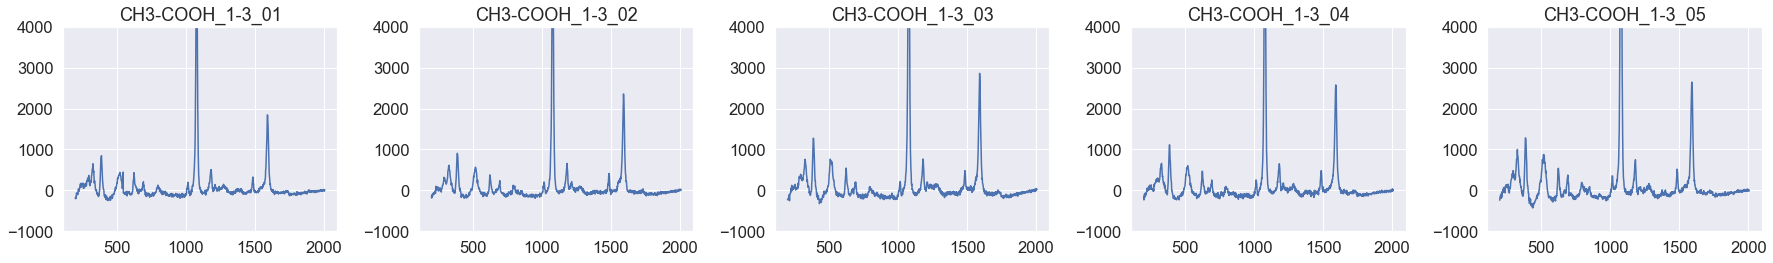

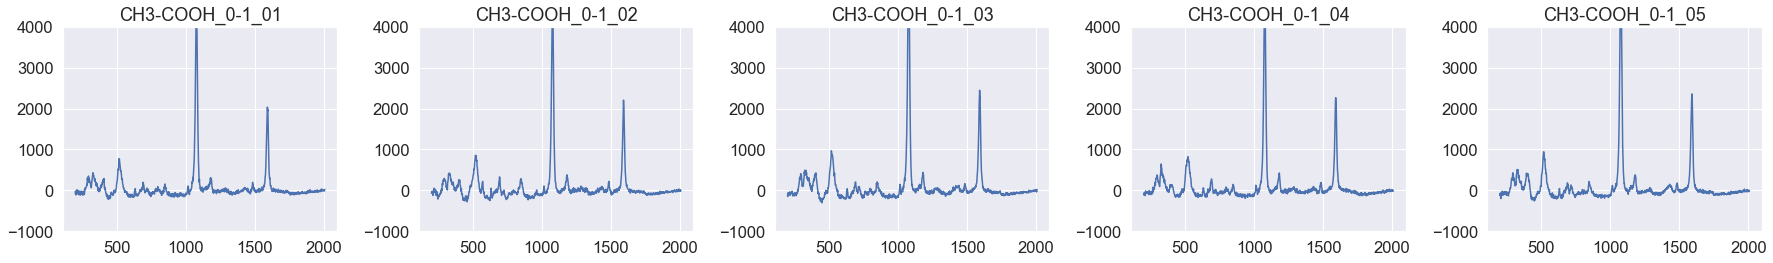

In [111]:
for df in df_list:
    yaxis_list = [y for y in df.columns if not 'Raman Shift' in y]
    plt.figure(figsize=(25, 4))
    for i in range(5):
        plt.subplot(1, 5, i+1)
        plt.plot(df['Raman Shift'] , df[yaxis_list[i]])
        plt.title(yaxis_list[i])
        plt.ylim(YLIM_MIN, YLIM_MAX)

        # x,y軸の目盛り設定
    
    # plt.xlabel(XLABEL, fontsize=FONTS_SIZE)
    # plt.ylabel(YLABEL, fontsize=FONTS_SIZE)
    # plt.xticks(fontsize=FONTS_SIZE)
    # plt.yticks(fontsize=FONTS_SIZE)
    plt.tight_layout()
    plt.show()

# データの前処理

In [12]:
scaled_df_list = []

# 最大強度を1にスケール化
for df in df_list:
    yaxis_list = [y for y in df.columns if not 'Raman Shift' in y]

    scaler = MinMaxScaler()
    series = scaler.fit_transform(df[yaxis_list])
    scaled_df = pd.DataFrame(series)
    scaled_df.columns = yaxis_list
    scaled_df.insert(0, 'Raman Shift', df['Raman Shift'])

    scaled_df_list.append(scaled_df)

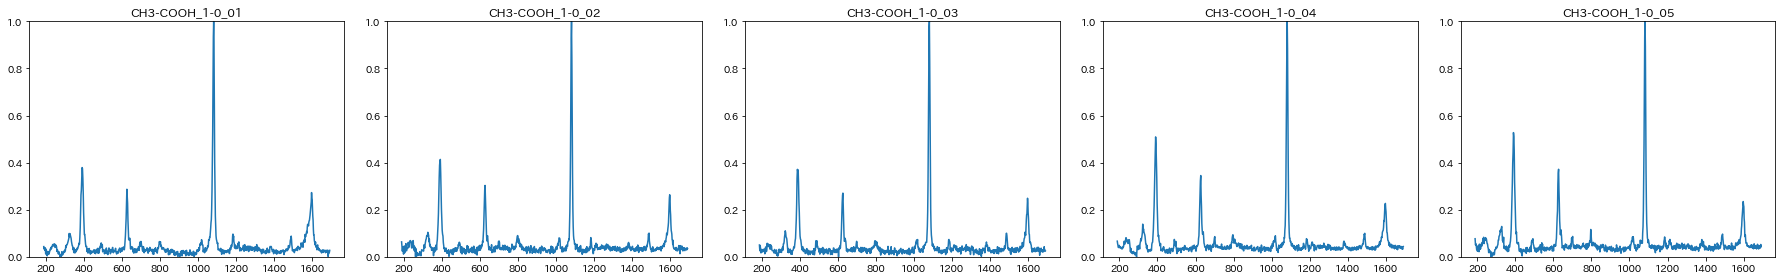

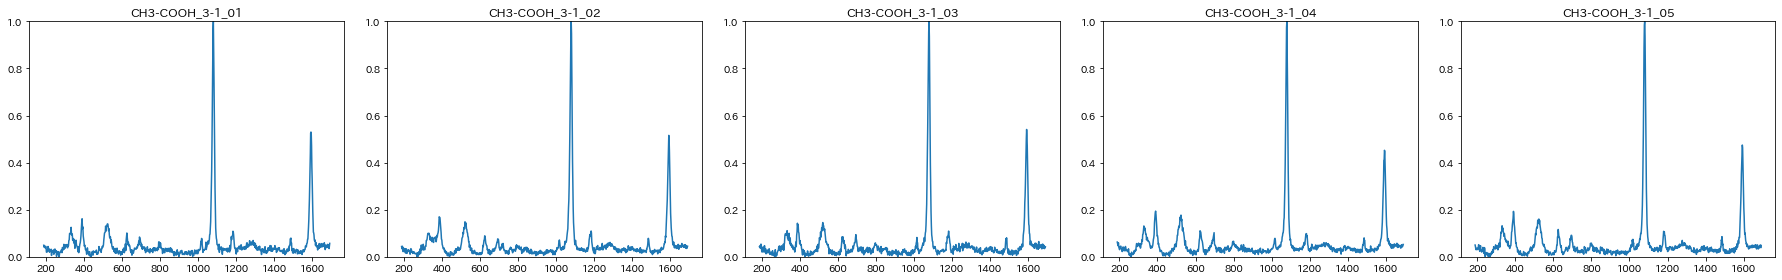

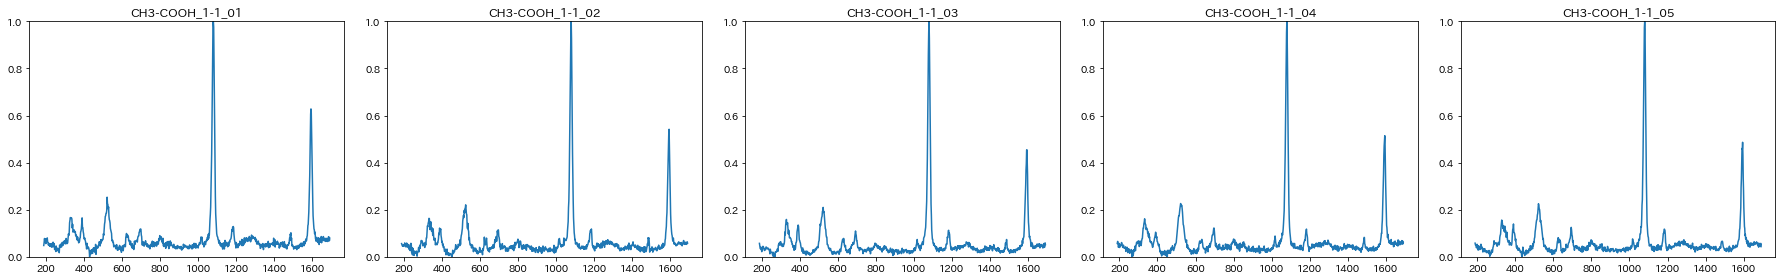

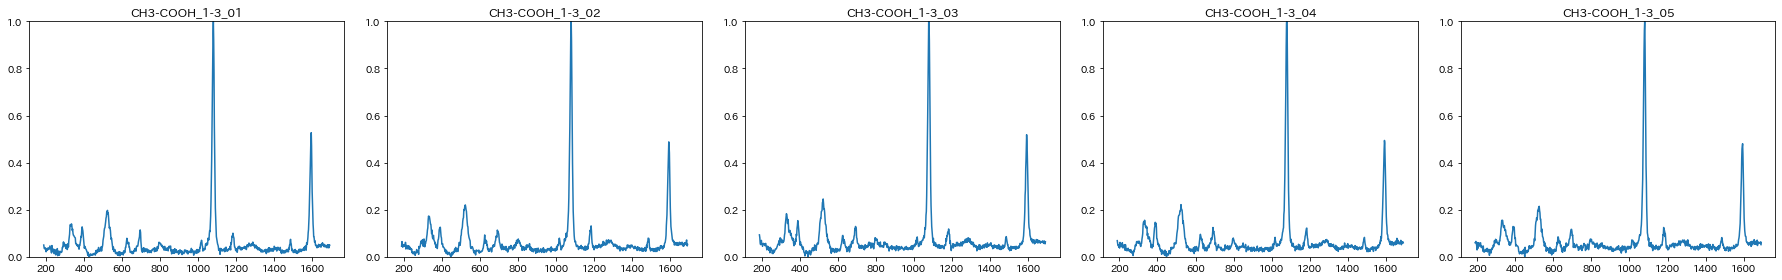

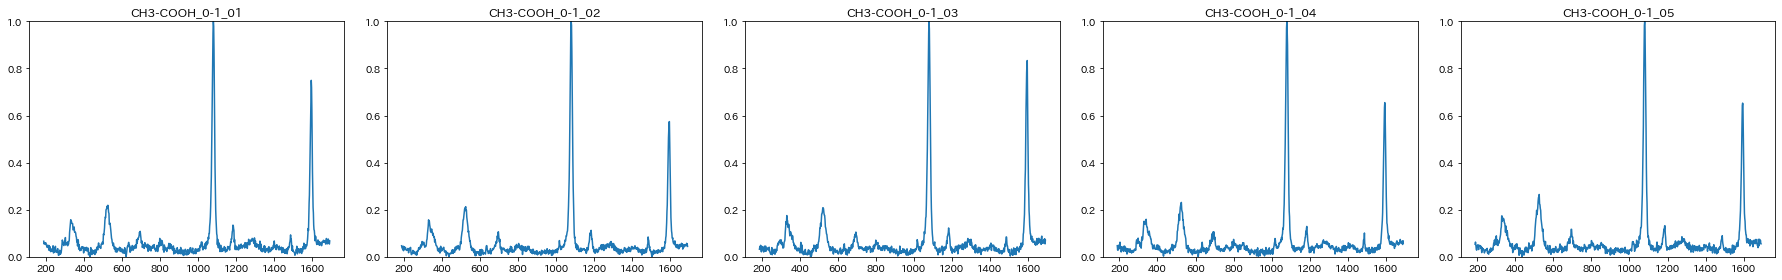

In [13]:
# Y軸の最大・最小の設定
YLIM_MIN = 0
YLIM_MAX = 1
for df in scaled_df_list:
    yaxis_list = [y for y in df.columns if not 'Raman Shift' in y]
    plt.figure(figsize=(25, 4))
    for i in range(5):
        plt.subplot(1, 5, i+1)
        plt.plot(df['Raman Shift'] , df[yaxis_list[i+25]])
        plt.title(yaxis_list[i])
        plt.ylim(YLIM_MIN, YLIM_MAX)

        # x,y軸の目盛り設定
        
    # plt.xlabel(XLABEL, fontsize=FONTS_SIZE)
    # plt.ylabel(YLABEL, fontsize=FONTS_SIZE)
    # plt.xticks(fontsize=FONTS_SIZE)
    # plt.yticks(fontsize=FONTS_SIZE)
    plt.tight_layout()
    plt.show()

In [15]:
# 解析用にデータフレームの形状を変更
RAMAN_SHIFT = df_list[0]['Raman Shift']
label_list = ['CH3:COOH=1:0', 'CH3:COOH=3:1', 'CH3:COOH=1:1', 'CH3:COOH=1:3', 'CH3:COOH=0:1']

for n, df in enumerate(scaled_df_list):
    df.loc[-1] = int(n)

data_df = pd.concat(scaled_df_list, axis=1)
data_df = data_df.drop(['Raman Shift'], axis=1)
data_df = data_df.T
# labelのみ別で保存
data_label = data_df[-1]
# label無しのデータフレーム
data_df = data_df.drop(-1, axis=1)
data_df.columns = RAMAN_SHIFT

In [90]:
# データの標準化
yaxis_list = [y for y in data_df.columns if not 'Raman Shift' in y]

std_scaler = StandardScaler()
std_series = std_scaler.fit_transform(data_df)
std_data_df = pd.DataFrame(std_series)
std_data_df.columns = yaxis_list
std_data_df.index = data_df.index

,201.192791188876,203.237476388369,205.281479548654,207.324801000766,209.367441075527,211.409400103543,213.450678415207,215.491276340697,217.53119420998,219.570432352812,...,1686.63277081232,1688.20924960475,1689.78526051501,1691.36080374343,1692.93587949023,1694.51048795554,1696.08462933935,1697.65830384154,1699.2315116619,1700.80425300006
count,2.500000e+02,2.500000e+02,2.500000e+02,2.500000e+02,2.500000e+02,2.500000e+02,2.500000e+02,2.500000e+02,2.500000e+02,2.500000e+02,...,2.500000e+02,2.500000e+02,2.500000e+02,2.500000e+02,2.500000e+02,2.500000e+02,2.500000e+02,2.500000e+02,2.500000e+02,2.500000e+02
mean,1.705303e-16,8.526513e-16,8.242296e-16,-3.410605e-16,4.263256e-16,2.273737e-16,1.136868e-15,-1.165290e-15,-8.668621e-16,3.367973e-15,...,2.273737e-16,7.389644e-16,1.023182e-15,-2.842171e-17,-2.557954e-16,1.023182e-15,1.705303e-15,1.108447e-15,-2.557954e-16,-7.105427e-16
std,1.002006e+00,1.002006e+00,1.002006e+00,1.002006e+00,1.002006e+00,1.002006e+00,1.002006e+00,1.002006e+00,1.002006e+00,1.002006e+00,...,1.002006e+00,1.002006e+00,1.002006e+00,1.002006e+00,1.002006e+00,1.002006e+00,1.002006e+00,1.002006e+00,1.002006e+00,1.002006e+00
min,-1.690633e+00,-1.668604e+00,-1.899661e+00,-1.882878e+00,-2.073268e+00,-2.457001e+00,-2.145751e+00,-2.182552e+00,-2.866211e+00,-2.026111e+00,...,-2.508658e+00,-2.906844e+00,-2.371323e+00,-2.749224e+00,-2.571816e+00,-2.719466e+00,-2.201654e+00,-2.534485e+00,-2.636854e+00,-2.179609e+00
25%,-6.810597e-01,-7.088316e-01,-7.010133e-01,-6.903018e-01,-6.501984e-01,-7.184729e-01,-7.103830e-01,-7.437125e-01,-7.215593e-01,-6.556897e-01,...,-7.560369e-01,-7.215328e-01,-6.725005e-01,-7.067497e-01,-7.032689e-01,-7.639777e-01,-6.809292e-01,-6.922931e-01,-6.894481e-01,-6.739367e-01
50%,-2.334526e-02,-7.488722e-02,-1.396425e-01,-5.906905e-02,-1.122022e-01,-9.148547e-03,-1.138728e-01,-1.119491e-01,-1.161088e-01,-6.130705e-02,...,-3.518511e-02,-2.470252e-02,3.733045e-03,-4.029476e-02,6.885006e-03,2.595921e-02,-1.377547e-01,-3.716761e-02,3.300030e-02,-5.442697e-02
75%,5.227439e-01,5.795272e-01,6.498618e-01,5.811807e-01,5.597585e-01,6.135570e-01,6.442129e-01,6.031168e-01,6.684556e-01,4.814025e-01,...,6.685140e-01,7.120441e-01,7.058638e-01,6.733310e-01,6.935687e-01,6.846855e-01,6.108322e-01,6.923988e-01,4.865781e-01,6.237678e-01
max,6.286072e+00,6.315591e+00,5.366375e+00,4.847545e+00,5.219045e+00,3.749038e+00,3.563240e+00,2.818815e+00,3.277079e+00,4.651071e+00,...,3.451244e+00,2.517052e+00,2.715638e+00,3.080602e+00,3.034953e+00,2.604830e+00,3.047216e+00,2.814492e+00,3.165524e+00,3.744969e+00


# PCA

In [21]:
pca = PCA(n_components=2)

X = pca.fit_transform(data_df.values)
pca_result_df = pd.DataFrame(X)
pca_result_df.columns = ['PC1', 'PC2']
pca_result_df['label'] = data_label.values
pca_result_df.head()

,PC1,PC2,label
0,1.196323,-0.382457,0.0
1,1.083939,-0.366675,0.0
2,1.017576,-0.337649,0.0
3,1.012921,-0.185011,0.0
4,1.039285,-0.295704,0.0


In [22]:
data_1 = pca_result_df[pca_result_df['label'] == 0]
data_2 = pca_result_df[pca_result_df['label'] == 1]
data_3 = pca_result_df[pca_result_df['label'] == 2]
data_4 = pca_result_df[pca_result_df['label'] == 3]
data_5 = pca_result_df[pca_result_df['label'] == 4]

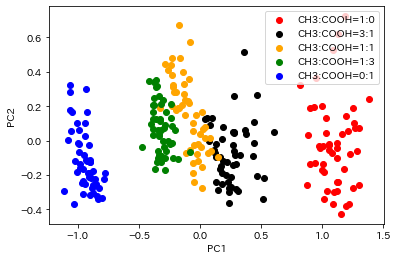

In [23]:
plt.scatter(data_1['PC1'], data_1['PC2'], c='red', label='CH3:COOH=1:0')
plt.scatter(data_2['PC1'], data_2['PC2'], c='black', label='CH3:COOH=3:1')
plt.scatter(data_3['PC1'], data_3['PC2'], c='orange', label='CH3:COOH=1:1')
plt.scatter(data_4['PC1'], data_4['PC2'], c='green', label='CH3:COOH=1:3')
plt.scatter(data_5['PC1'], data_5['PC2'], c='blue', label='CH3:COOH=0:1')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(loc='best')
plt.show()

In [24]:
# 寄与率の算出
df_exp_var_ratio = pd.DataFrame([pca.explained_variance_ratio_],columns=['PC1', 'PC2'])
df_exp_var_ratio.head()

,PC1,PC2
0,0.767717,0.07958


In [25]:
#各主成分の固有ベクトル
pca_vec_df = pd.DataFrame(pca.components_, columns=data_df.columns, index=['PC1', 'PC2'])
pca_vec_df

Raman Shift,201.192791,203.237476,205.281480,207.324801,209.367441,211.409400,213.450678,215.491276,217.531194,219.570432,...,1686.632771,1688.209250,1689.785261,1691.360804,1692.935879,1694.510488,1696.084629,1697.658304,1699.231512,1700.804253
PC1,-0.003497,-0.005434,-0.005442,-0.006273,-0.005661,-0.005519,-0.006115,-0.005736,-0.003998,-0.003206,...,-0.006388,-0.006275,-0.005952,-0.006010,-0.005899,-0.005356,-0.005203,-0.004887,-0.004227,-0.004454
PC2,0.010963,0.012491,0.013584,0.014493,0.014029,0.013492,0.019738,0.019995,0.022034,0.024839,...,0.017442,0.017691,0.017891,0.019765,0.017211,0.018387,0.018830,0.016720,0.017277,0.019355


<AxesSubplot:xlabel='Raman Shift'>

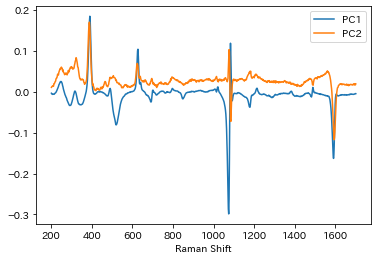

In [26]:
pca_vec_df.T.plot()

In [27]:
pca.explained_variance_

array([0.4642463 , 0.04812305])

# 予測

In [28]:
def pca_svm(n_comp, data_df, label):
    # PCA処理
    pca = PCA(n_components=n_comp)
    X = pca.fit_transform(data_df.values)
    result_df = pd.DataFrame(X)
    result_df.columns = [f'PC{n+1}' for n in range(n_comp)]
    result_df['label'] = label.values

    # 寄与率の算出
    df_exp_var_ratio = pd.DataFrame([pca.explained_variance_ratio_],columns=[f'PC{n+1}' for n in range(n_comp)])
    #各主成分の固有ベクトル
    pca_vec_df = pd.DataFrame(pca.components_, columns=data_df.columns, index=[f'PC{n+1}' for n in range(n_comp)])

    # SVM処理
    # 特徴量とラベルの分割
    X = result_df[result_df.columns[result_df.columns != 'label']]
    y = result_df['label']
    oof = np.zeros(len(y))

    kf = KFold(n_splits=5, shuffle=True, random_state=1234)
    for train_idx, val_idx in kf.split(X):
        train_x, val_x = X.iloc[train_idx], X.iloc[val_idx]
        train_y, val_y = y.iloc[train_idx], y.iloc[val_idx]

        svm_model = SVC()
        svm_model.fit(train_x, train_y)
        y_pred = svm_model.predict(val_x)
        oof[val_idx] = y_pred

    cm = confusion_matrix(y, oof)
    # 正解率
    Accuracy = accuracy_score(y, oof)


    return df_exp_var_ratio, pca_vec_df, cm, Accuracy

In [112]:
# train_accuracy計算用
def train_pca_svm(n_comp, data_df, label):
    # PCA処理
    pca = PCA(n_components=n_comp)
    X = pca.fit_transform(data_df.values)
    result_df = pd.DataFrame(X)
    result_df.columns = [f'PC{n+1}' for n in range(n_comp)]
    result_df['label'] = label.values

    # 寄与率の算出
    df_exp_var_ratio = pd.DataFrame([pca.explained_variance_ratio_],columns=[f'PC{n+1}' for n in range(n_comp)])
    #各主成分の固有ベクトル
    pca_vec_df = pd.DataFrame(pca.components_, columns=data_df.columns, index=[f'PC{n+1}' for n in range(n_comp)])

    # SVM処理
    # 特徴量とラベルの分割
    X = result_df[result_df.columns[result_df.columns != 'label']]
    y = result_df['label']

    svm_model = SVC()
    svm_model.fit(X, y)
    y_pred = svm_model.predict(X)

    cm = confusion_matrix(y, y_pred)
    # 正解率
    Accuracy = accuracy_score(y, y_pred)


    return df_exp_var_ratio, pca_vec_df, cm, Accuracy

# PCA_SVMの検討

In [29]:
# n_components = 2
raitio_2, _, cm_2, accuracy_2 = pca_svm(2, data_df, data_label)
print(raitio_2)
print(accuracy_2)

        PC1      PC2
0  0.767717  0.07958
0.964


<AxesSubplot:>

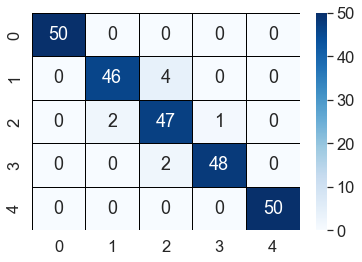

In [30]:
sns.set(font_scale=1.5)
sns.heatmap(cm_2, annot=True, cmap='Blues', linecolor='black', linewidths=1)

In [31]:
# n_components = 3
raitio_3, _, cm_3, accuracy_3 = pca_svm(3, data_df, data_label)
print(raitio_3)
print(accuracy_3)

        PC1      PC2       PC3
0  0.767717  0.07958  0.051269
0.968


<AxesSubplot:>

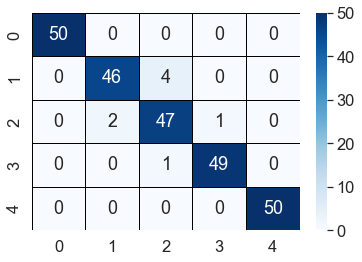

In [32]:
sns.set(font_scale=1.5)
sns.heatmap(cm_3, annot=True, cmap='Blues', linecolor='black', linewidths=1)

## 学習データでの精度

In [113]:
# train_accuracy
train_raitio_3, _, train_cm_3, train_accuracy_3 = train_pca_svm(3, data_df, data_label)
print(train_raitio_3)
print(train_accuracy_3)

        PC1      PC2       PC3
0  0.767717  0.07958  0.051269
0.968


<AxesSubplot:>

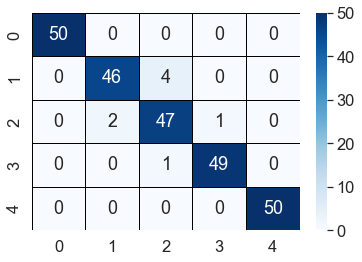

In [114]:
sns.set(font_scale=1.5)
sns.heatmap(train_cm_3, annot=True, cmap='Blues', linecolor='black', linewidths=1)

## ここまで

In [91]:
# 標準化データでの予測
std_raitio_3, _, std_cm_3, std_accuracy_3 = pca_svm(3, std_data_df, data_label)
print(std_raitio_3)
print(std_accuracy_3)

        PC1       PC2       PC3
0  0.440292  0.180613  0.055657
0.82


<AxesSubplot:>

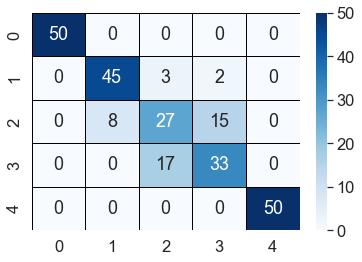

In [92]:
sns.set(font_scale=1.5)
sns.heatmap(std_cm_3, annot=True, cmap='Blues', linecolor='black', linewidths=1)

In [33]:
# n_components = 5
raitio_5, _, cm_5, accuracy_5 = pca_svm(5, data_df, data_label)
print(raitio_5)
print(accuracy_5)

        PC1      PC2       PC3       PC4       PC5
0  0.767717  0.07958  0.051269  0.016162  0.013143
0.964


<AxesSubplot:>

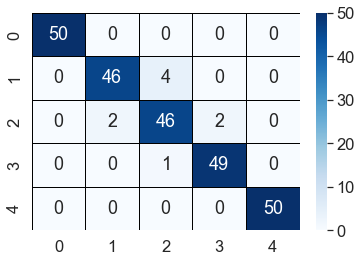

In [34]:
sns.set(font_scale=1.5)
sns.heatmap(cm_5, annot=True, cmap='Blues', linecolor='black', linewidths=1)

# SVM単体での解析

In [37]:
def svm_only(data_df, label):
    # SVM処理
    # 特徴量とラベルの分割
    X = data_df
    X.columns = [str(i) for i in data_df.columns]
    y = label
    oof = np.zeros(len(y))

    kf = KFold(n_splits=5, shuffle=True, random_state=1234)
    for train_idx, val_idx in kf.split(X):
        train_x, val_x = X.iloc[train_idx], X.iloc[val_idx]
        train_y, val_y = y.iloc[train_idx], y.iloc[val_idx]

        svm_model = SVC()
        svm_model.fit(train_x, train_y)
        y_pred = svm_model.predict(val_x)
        oof[val_idx] = y_pred

    cm = confusion_matrix(y, oof)
    # 正解率
    Accuracy = accuracy_score(y, oof)

    return cm, Accuracy

In [38]:
cm_svm, accuracy_svm = svm_only(data_df, data_label)
print('Accuracy:', accuracy_svm)

Accuracy: 0.828


<AxesSubplot:>

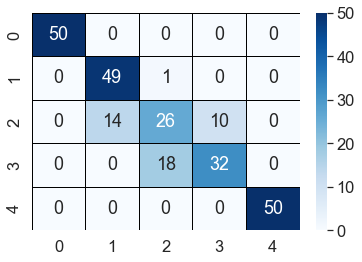

In [39]:
sns.set(font_scale=1.5)
sns.heatmap(cm_svm, annot=True, cmap='Blues', linecolor='black', linewidths=1)

In [93]:
# 標準化データでの予測
std_cm_svm, std_accuracy_svm = svm_only(std_data_df, data_label)
print('Accuracy:', std_accuracy_svm)

Accuracy: 0.876


<AxesSubplot:>

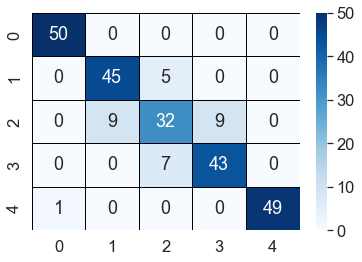

In [94]:
sns.set(font_scale=1.5)
sns.heatmap(std_cm_svm, annot=True, cmap='Blues', linecolor='black', linewidths=1)

## 学習データでの精度

In [116]:
def train_svm_only(data_df, label):
    # SVM処理
    # 特徴量とラベルの分割
    X = data_df
    X.columns = [str(i) for i in data_df.columns]
    y = label

    svm_model = SVC()
    svm_model.fit(X, y)
    y_pred = svm_model.predict(X)

    cm = confusion_matrix(y, y_pred)
    # 正解率
    Accuracy = accuracy_score(y, y_pred)

    return cm, Accuracy

In [117]:
train_cm_svm, train_accuracy_svm = train_svm_only(data_df, data_label)
print('Accuracy:', train_accuracy_svm)

Accuracy: 0.94


# Linear Discriminant Analysis(LDA)

explained variance ratio (first two components): [0.83223952 0.14417911]


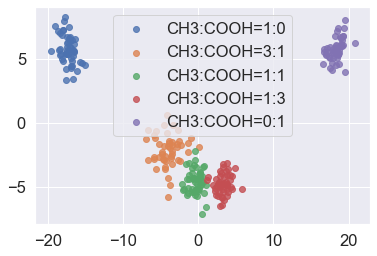

In [40]:
lda = LDA(n_components=2)
X_r2 = lda.fit(data_df, data_label).transform(data_df)

# Percentage of variance explained for each components
print('explained variance ratio (first two components): %s' % str(lda.explained_variance_ratio_))

plt.figure()
for i, label_name in zip([0, 1, 2, 3, 4], label_list):
    plt.scatter(X_r2[data_label == i, 0], X_r2[data_label == i, 1], alpha=.8,
    label=label_name)

plt.legend(loc='best', scatterpoints=1)
plt.show()

In [41]:
lda_result_df = pd.DataFrame(X_r2)
lda_result_df.columns = ['LDA1', 'LDA2']
lda_result_df['label'] = data_label.values
lda_result_df.head()

,LDA1,LDA2,label
0,-17.293287,6.289802,0.0
1,-17.365373,6.238300,0.0
2,-15.755472,4.773137,0.0
3,-17.015519,6.721785,0.0
4,-17.517314,4.226732,0.0


In [43]:
def lda_prediction(n_comp, data_df, label):

    X = data_df
    y = label
    oof = np.zeros(len(y))

    kf = KFold(n_splits=5, shuffle=True, random_state=1234)
    for train_idx, val_idx in kf.split(X):
        train_x, val_x = X.iloc[train_idx], X.iloc[val_idx]
        train_y, val_y = y.iloc[train_idx], y.iloc[val_idx]

        lda_model = LDA(n_components=n_comp)
        lda_model.fit(train_x, train_y)
        y_pred = lda_model.predict(val_x)
        oof[val_idx] = y_pred

    cm = confusion_matrix(y, oof)
    # 正解率
    Accuracy = accuracy_score(y, oof)

    return cm, Accuracy

In [44]:
cm_lda2, accuracy_lda2 = lda_prediction(2, data_df, data_label)
print('Accuracy:', accuracy_lda2)

Accuracy: 0.952


<AxesSubplot:>

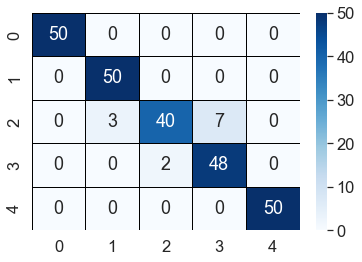

In [45]:
sns.set(font_scale=1.5)
sns.heatmap(cm_lda2, annot=True, cmap='Blues', linecolor='black', linewidths=1)

In [95]:
# 標準化データでの予測
std_cm_lda2, std_accuracy_lda2 = lda_prediction(2, std_data_df, data_label)
print('Accuracy:', std_accuracy_lda2)

Accuracy: 0.952


<AxesSubplot:>

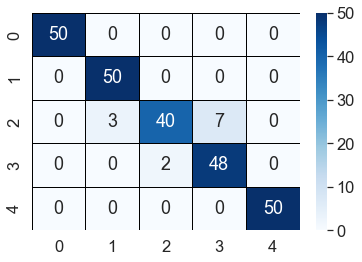

In [96]:
sns.set(font_scale=1.5)
sns.heatmap(std_cm_lda2, annot=True, cmap='Blues', linecolor='black', linewidths=1)

In [46]:
cm_lda3, accuracy_lda3 = lda_prediction(3, data_df, data_label)
print('Accuracy:', accuracy_lda3)

Accuracy: 0.952


<AxesSubplot:>

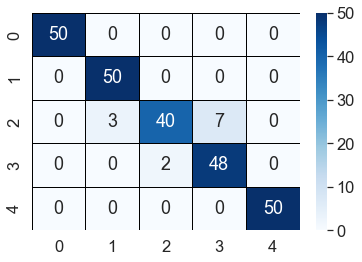

In [47]:
sns.set(font_scale=1.5)
sns.heatmap(cm_lda3, annot=True, cmap='Blues', linecolor='black', linewidths=1)

## 学習データでの精度

In [118]:
def train_lda_prediction(n_comp, data_df, label):

    X = data_df
    y = label

    lda_model = LDA(n_components=n_comp)
    lda_model.fit(X, y)
    y_pred = lda_model.predict(X)

    cm = confusion_matrix(y, y_pred)
    # 正解率
    Accuracy = accuracy_score(y, y_pred)

    return cm, Accuracy

In [119]:
train_cm_lda2, train_accuracy_lda2 = train_lda_prediction(2, data_df, data_label)
print('Accuracy:', train_accuracy_lda2)

Accuracy: 0.996


# DTWによるクラスタリング

In [15]:
dtw_data = TimeSeriesScalerMeanVariance().fit_transform(data_df)

km_euclidean = TimeSeriesKMeans(n_clusters=5, random_state=42, metric="dtw")
dtw_labels = km_euclidean.fit_predict(dtw_data)

In [16]:
dtw_labels

array([4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 1, 1, 4, 1, 4, 4, 4, 4, 4, 4, 1, 1,
       4, 1, 1, 4, 4, 4, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 4, 4, 1, 1, 1,
       4, 4, 4, 4, 1, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 2, 2, 0, 2, 2, 2, 2,
       0, 3, 2, 0, 2, 0, 2, 2, 2, 2, 0, 3, 3, 2, 2, 2, 2, 2, 2, 2, 0, 0,
       0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 0, 0, 2, 0, 2, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,
       0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [29]:
dtw_df = pd.DataFrame()
dtw_df['label'] = data_label
dtw_df['cluster'] = dtw_labels
dtw_df

,label,cluster
CH3-COOH_1-0_01,0.0,4
CH3-COOH_1-0_02,0.0,4
CH3-COOH_1-0_03,0.0,4
CH3-COOH_1-0_04,0.0,1
CH3-COOH_1-0_05,0.0,4
...,...,...
CH3-COOH_0-1_46,4.0,0
CH3-COOH_0-1_47,4.0,0
CH3-COOH_0-1_48,4.0,0
CH3-COOH_0-1_49,4.0,0


# t-SNEによるクラスタリング

In [48]:
tsne = TSNE(n_components=2, random_state=0, init='pca', learning_rate='auto')

X = tsne.fit_transform(data_df.values)
tsne_result_df = pd.DataFrame(X)
tsne_result_df.columns = ['tSNE1', 'tSNE2']
tsne_result_df['label'] = data_label.values
tsne_result_df.head()

c:\Users\west7\anaconda3\envs\xeus-python\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


,tSNE1,tSNE2,label
0,30.971167,-5.352724,0.0
1,30.492462,-5.642716,0.0
2,29.982548,-5.875404,0.0
3,28.990528,-6.103486,0.0
4,29.910818,-5.622655,0.0


In [49]:
data_1 = tsne_result_df[tsne_result_df['label'] == 0]
data_2 = tsne_result_df[tsne_result_df['label'] == 1]
data_3 = tsne_result_df[tsne_result_df['label'] == 2]
data_4 = tsne_result_df[tsne_result_df['label'] == 3]
data_5 = tsne_result_df[tsne_result_df['label'] == 4]

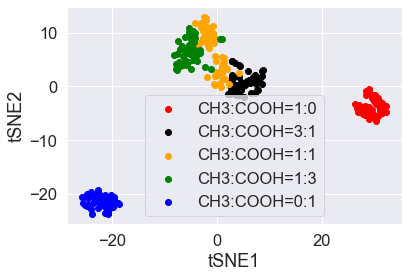

In [50]:
plt.scatter(data_1['tSNE1'], data_1['tSNE2'], c='red', label='CH3:COOH=1:0')
plt.scatter(data_2['tSNE1'], data_2['tSNE2'], c='black', label='CH3:COOH=3:1')
plt.scatter(data_3['tSNE1'], data_3['tSNE2'], c='orange', label='CH3:COOH=1:1')
plt.scatter(data_4['tSNE1'], data_4['tSNE2'], c='green', label='CH3:COOH=1:3')
plt.scatter(data_5['tSNE1'], data_5['tSNE2'], c='blue', label='CH3:COOH=0:1')
plt.xlabel('tSNE1')
plt.ylabel('tSNE2')
plt.legend(loc='best')
plt.show()

# t-SNE_SVMの解析

In [97]:
def tsne_svm(n_comp, data_df, label):
    # t-SNE処理
    tsne = TSNE(n_components=n_comp, random_state=0, init='pca', learning_rate='auto')
    X = tsne.fit_transform(data_df.values)
    result_df = pd.DataFrame(X)
    result_df.columns = [f'TSNE{n+1}' for n in range(n_comp)]
    result_df['label'] = label.values

    # SVM処理
    # 特徴量とラベルの分割
    X = result_df[result_df.columns[result_df.columns != 'label']]
    y = result_df['label']
    oof = np.zeros(len(y))

    kf = KFold(n_splits=5, shuffle=True, random_state=1234)
    for train_idx, val_idx in kf.split(X):
        train_x, val_x = X.iloc[train_idx], X.iloc[val_idx]
        train_y, val_y = y.iloc[train_idx], y.iloc[val_idx]

        svm_model = SVC()
        svm_model.fit(train_x, train_y)
        y_pred = svm_model.predict(val_x)
        oof[val_idx] = y_pred

    cm = confusion_matrix(y, oof)
    # 正解率
    Accuracy = accuracy_score(y, oof)

    return cm, Accuracy

In [98]:
# componet=2
cm_tsne_svm, accuracy_tsne_svm = tsne_svm(2, data_df, data_label)
print('Accuracy:', accuracy_tsne_svm)

c:\Users\west7\anaconda3\envs\xeus-python\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


Accuracy: 0.936


<AxesSubplot:>

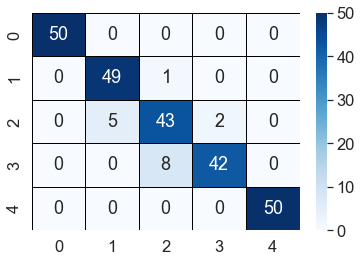

In [99]:
sns.set(font_scale=1.5)
sns.heatmap(cm_tsne_svm, annot=True, cmap='Blues', linecolor='black', linewidths=1)

In [100]:
# 標準化データでの予測
# componet=2
std_cm_tsne_svm, std_accuracy_tsne_svm = tsne_svm(2, std_data_df, data_label)
print('Accuracy:', std_accuracy_tsne_svm)

c:\Users\west7\anaconda3\envs\xeus-python\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


Accuracy: 0.72


In [54]:
# componet=3
cm_tsne_svm, accuracy_tsne_svm = tsne_svm(3, data_df, data_label)
print('Accuracy:', accuracy_tsne_svm)

c:\Users\west7\anaconda3\envs\xeus-python\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
c:\Users\west7\anaconda3\envs\xeus-python\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


Accuracy: 0.764


<AxesSubplot:>

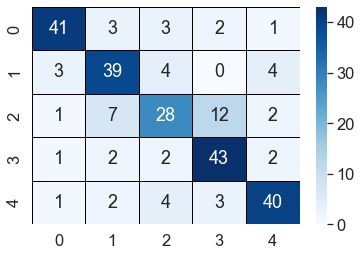

In [55]:
sns.set(font_scale=1.5)
sns.heatmap(cm_tsne_svm, annot=True, cmap='Blues', linecolor='black', linewidths=1)

## 学習データでの精度

In [130]:
def train_tsne_svm(n_comp, data_df, label):
    # t-SNE処理
    tsne = TSNE(n_components=n_comp, random_state=0, init='pca', learning_rate='auto')
    X = tsne.fit_transform(data_df.values)
    result_df = pd.DataFrame(X)
    result_df.columns = [f'TSNE{n+1}' for n in range(n_comp)]
    result_df['label'] = label.values

    # SVM処理
    # 特徴量とラベルの分割
    X = result_df[result_df.columns[result_df.columns != 'label']]
    y = result_df['label']

    svm_model = SVC()
    svm_model.fit(X, y)
    y_pred = svm_model.predict(X)

    cm = confusion_matrix(y, y_pred)
    # 正解率
    Accuracy = accuracy_score(y, y_pred)

    return cm, Accuracy

In [131]:
# componet=2
train_cm_tsne_svm, train_accuracy_tsne_svm = train_tsne_svm(2, data_df, data_label)
print('Accuracy:', train_accuracy_tsne_svm)

c:\Users\west7\anaconda3\envs\xeus-python\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


Accuracy: 0.956


# 決定木によるクラスタリング

In [56]:
def decision_tree(data_df, label, max_depth):
    # 特徴量とラベルの分割
    X = data_df
    X.columns = [str(i) for i in data_df.columns]
    y = label
    oof = np.zeros(len(y))

    kf = KFold(n_splits=5, shuffle=True, random_state=1234)
    for train_idx, val_idx in kf.split(X):
        train_x, val_x = X.iloc[train_idx], X.iloc[val_idx]
        train_y, val_y = y.iloc[train_idx], y.iloc[val_idx]

        dt_model = DecisionTreeClassifier(max_depth=max_depth, 
                                          min_samples_split=2,
                                          min_samples_leaf=1,
                                          max_leaf_nodes=None,
                                          random_state=1234)
        
        dt_model.fit(train_x, train_y)
        y_pred = dt_model.predict(val_x)
        oof[val_idx] = y_pred

    cm = confusion_matrix(y, oof)
    # 正解率
    Accuracy = accuracy_score(y, oof)

    return cm, Accuracy

In [125]:
max_depth = 5
cm_dt, accuracy_dt = decision_tree(data_df, data_label, max_depth)
print('Accuracy:', accuracy_dt)

Accuracy: 0.908


<AxesSubplot:>

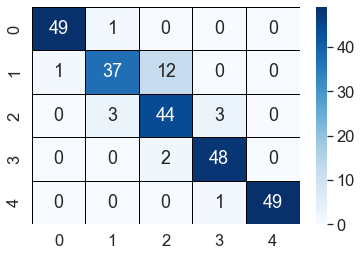

In [58]:
sns.set(font_scale=1.5)
sns.heatmap(cm_dt, annot=True, cmap='Blues', linecolor='black', linewidths=1)

## 学習データでの精度

In [128]:
def train_decision_tree(data_df, label, max_depth):
    # 特徴量とラベルの分割
    X = data_df
    X.columns = [str(i) for i in data_df.columns]
    y = label

    dt_model = DecisionTreeClassifier(max_depth=max_depth, 
                                        min_samples_split=2,
                                        min_samples_leaf=1,
                                        max_leaf_nodes=None,
                                        random_state=1234)
    
    dt_model.fit(X, y)
    y_pred = dt_model.predict(X)

    cm = confusion_matrix(y, y_pred)
    # 正解率
    Accuracy = accuracy_score(y, y_pred)

    return cm, Accuracy

In [129]:
max_depth = 5
train_cm_dt, train_accuracy_dt = train_decision_tree(data_df, data_label, max_depth)
print('Accuracy:', train_accuracy_dt)

Accuracy: 0.988


# MLPによるクラスタリング

In [167]:
def MLP(data_df, label):
    # 特徴量とラベルの分割
    X = data_df
    X.columns = [str(i) for i in data_df.columns]
    y = label
    oof = np.zeros(len(y))

    kf = KFold(n_splits=5, shuffle=True, random_state=1234)
    for train_idx, val_idx in kf.split(X):
        train_x, val_x = X.iloc[train_idx], X.iloc[val_idx]
        train_y, val_y = y.iloc[train_idx], y.iloc[val_idx]

        MLP_model = MLPClassifier(hidden_layer_sizes=(100, 100),
                                  activation='relu', # logistic, tanh, relu
                                  solver='adam',
                                  max_iter=1000,
                                  random_state=1234)
        
        MLP_model.fit(train_x, train_y)
        y_pred = MLP_model.predict(val_x)
        oof[val_idx] = y_pred

    cm = confusion_matrix(y, oof)
    # 正解率
    Accuracy = accuracy_score(y, oof)

    return cm, Accuracy

In [168]:
cm_MLP, accuracy_MLP = MLP(data_df, data_label)
print('Accuracy:', accuracy_MLP)

Accuracy: 0.992


<AxesSubplot:>

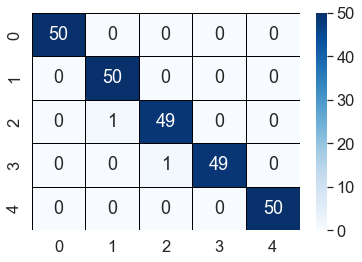

In [151]:
sns.set(font_scale=1.5)
sns.heatmap(cm_MLP, annot=True, cmap='Blues', linecolor='black', linewidths=1)

In [148]:
# 標準化データでの予測
std_cm_MLP, std_accuracy_MLP = MLP(std_data_df, data_label)
print('Accuracy:', std_accuracy_MLP)

Accuracy: 0.924


## 学習データでの精度

In [169]:
def train_MLP(data_df, label):
    # 特徴量とラベルの分割
    X = data_df
    X.columns = [str(i) for i in data_df.columns]
    y = label

    MLP_model = MLPClassifier(hidden_layer_sizes=(100, 100),
                                activation='relu',
                                solver='adam',
                                max_iter=1000,
                                random_state=1234)
    
    MLP_model.fit(X, y)
    y_pred = MLP_model.predict(X)

    cm = confusion_matrix(y, y_pred)
    # 正解率
    Accuracy = accuracy_score(y, y_pred)

    return cm, Accuracy

In [170]:
train_cm_MLP, train_accuracy_MLP = MLP(data_df, data_label)
print('Accuracy:', train_accuracy_MLP)

Accuracy: 0.992


<AxesSubplot:>

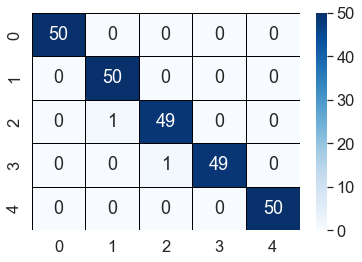

In [171]:
sns.set(font_scale=1.5)
sns.heatmap(train_cm_MLP, annot=True, cmap='Blues', linecolor='black', linewidths=1)

# データのExcel化

In [106]:
with pd.ExcelWriter(r'C:\Users\west7\OneDrive\デスクトップ\raman処理用\raw_data.xlsx') as writer:
    for n, df in enumerate(df_list):
        df.to_excel(writer, sheet_name=f'data_{n+1}', index=False)

In [103]:
pca_result_df.to_excel(r'C:\Users\west7\OneDrive\デスクトップ\raman処理用\pca_result.xlsx', index=False)

In [104]:
lda_result_df.to_excel(r'C:\Users\west7\OneDrive\デスクトップ\raman処理用\lda_result.xlsx', index=False)

In [105]:
tsne_result_df.to_excel(r'C:\Users\west7\OneDrive\デスクトップ\raman処理用\tsne_result.xlsx', index=False)

In [107]:
pca_vec_df.T.to_excel(r'C:\Users\west7\OneDrive\デスクトップ\raman処理用\vector.xlsx', index=False)